In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tqdm import tqdm

## Database Connection and Data Loading

In [2]:
# Define the connection parameters
host = 'localhost'
dbname = 'StarsGalaxiesQuasars'
user = 'postgres'
password = '121792'
port = '5432'

# Create the connection string
connection = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

# Create a connection engine using SQLAlchemy
engine = create_engine(connection)

In [3]:
# Write a SQL query to join the observation and classification tables
join_query = """
SELECT o.*, c.class
FROM observation o
JOIN classification c ON o.classid = c.classid;
"""

In [4]:
# Load the data into a Pandas DataFrame
database_df = pd.read_sql(join_query, engine)

## Exploratory Data Analysis (EDA)

In [5]:
# Check DataFrame
database_df.head()

,observationid,classid,objid,ra,dec,u,g,r,i,z,redshift,run,rerun,camcol,field,specobjid,plate,mjd,fiberid,class
0,1,1,1237650000000000000,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752.0,301,4,267,3.722360e+18,-8.96e-06,3306,54922,491,STAR
1,2,1,1237650000000000000,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752.0,301,4,267,3.638140e+17,-5.49e-05,323,51615,541,STAR
2,3,2,1237650000000000000,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752.0,301,4,268,3.232740e+17,0.1231112,287,52023,513,GALAXY
3,4,1,1237650000000000000,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752.0,301,4,269,3.722370e+18,-0.000110616,3306,54922,510,STAR
4,5,1,1237650000000000000,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752.0,301,4,269,3.722370e+18,0.000590357,3306,54922,512,STAR


C:\Users\Ian O'Connor\AppData\Local\Temp\ipykernel_53876\2057781444.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=database_df, x='class', palette='viridis')


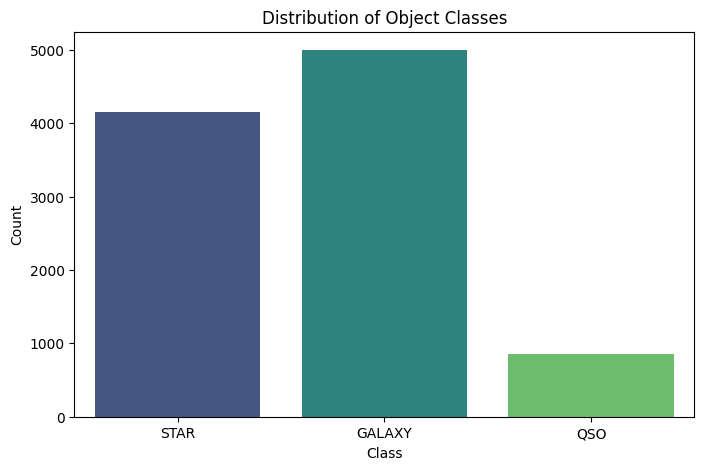

In [ ]:
# Count plot of different classes
plt.figure(figsize=(8, 5))
sns.countplot(data=database_df, x='class', palette='viridis')
plt.title("Distribution of Object Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

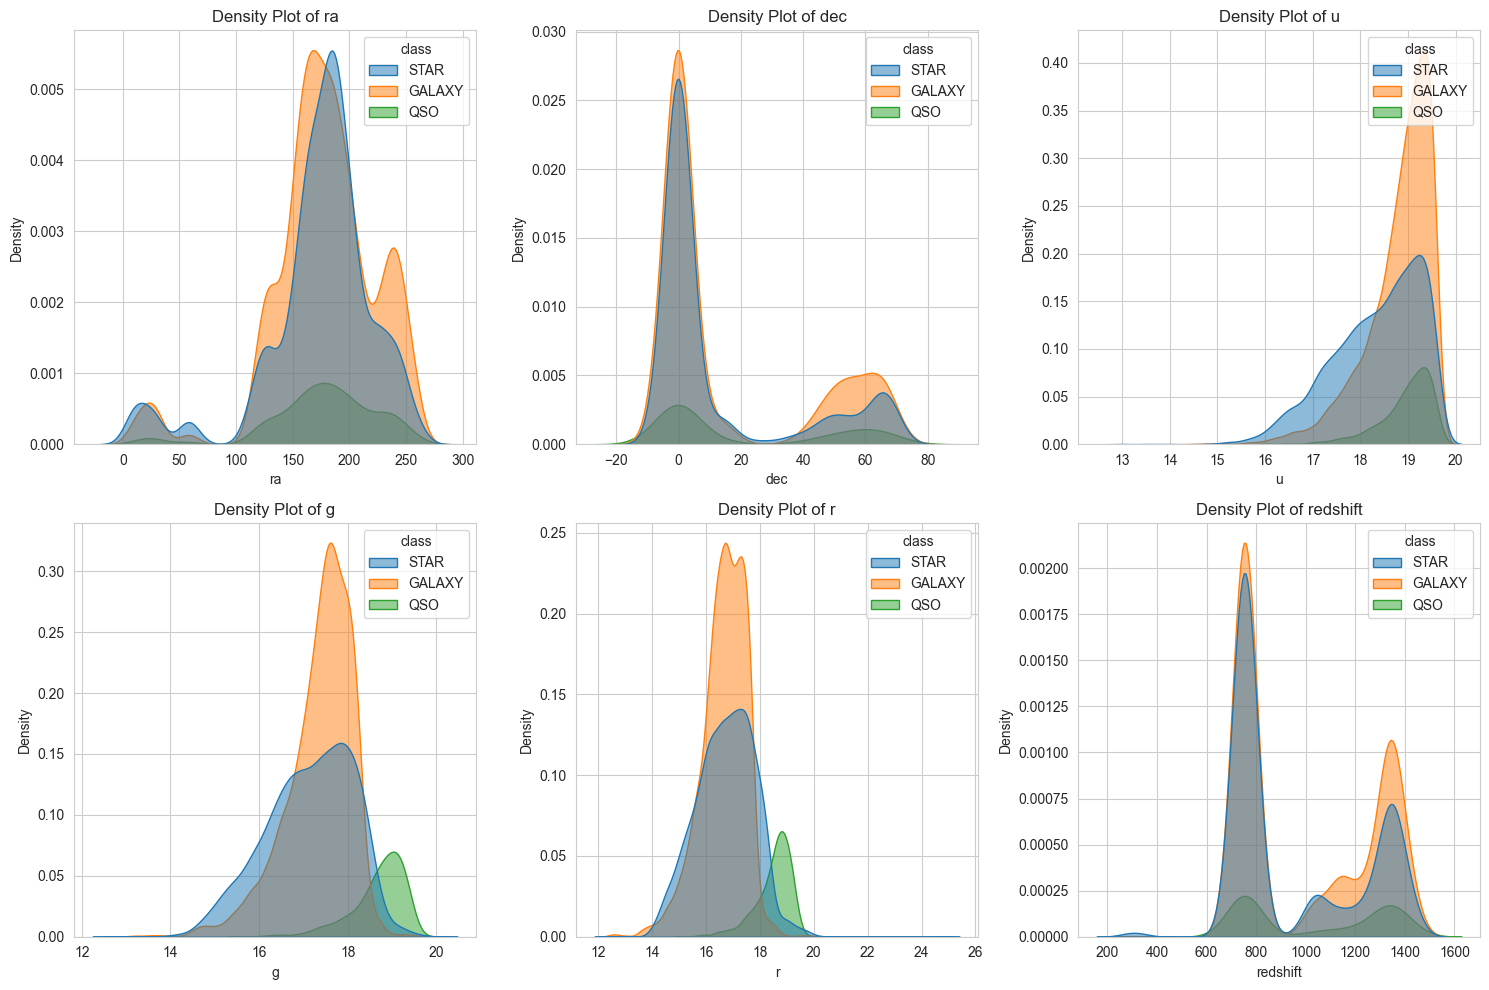

In [7]:
# Set plot style
sns.set_style("whitegrid")

# Density plots for numerical columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = ['ra', 'dec', 'u', 'g', 'r', 'redshift']
for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    sns.kdeplot(data=database_df, x=feature, hue='class', fill=True, ax=axes[row, col], alpha=0.5)
    axes[row, col].set_title(f"Density Plot of {feature}")

plt.tight_layout()
plt.show()

In [8]:
# 3D Scatter Plot of RA, DEC, and Redshift
fig = px.scatter_3d(database_df, x='ra', y='dec', z='redshift', color='class', opacity=0.7)
fig.update_layout(title="3D Scatter Plot of RA, DEC, and Redshift")
fig.show()

## Data Preprocessing

In [9]:
# Drop non-numeric columns except 'class'
ml = database_df.drop(columns=['observationid', 'classid', 'objid', 'specobjid', 'run', 'rerun', 'camcol', 'field', 'fiberid', 'plate', 'mjd', 'ra', 'dec', 'redshift'])

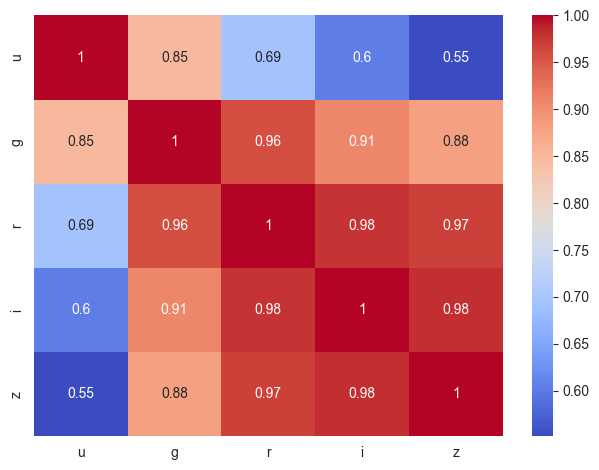

In [10]:
# Check for data leakage: Look for strong correlations between features and target class
# Select only the numeric columns for correlation analysis
numeric_df = ml.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

In [11]:
# Encode categorical target variable
le = LabelEncoder()
ml['class'] = le.fit_transform(ml['class'])

In [12]:
# Separate the data into labels and features
y = database_df['class'].map({'STAR': 0, 'GALAXY': 1, 'QSO': 2})
X = ml.drop(columns=['class'])

## Splitting Data

In [13]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Feature Scaling

In [14]:
# Initialize StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

## Model Training (Gradient Boosting)

In [15]:
# Initialize and train the Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=42)

In [16]:
# Make predictions
y_pred_gb = model.predict(X_test_scaled)

In [17]:
# Evaluate the model against the true class labels
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb):.2f}")
print(classification_report(y_test, y_pred_gb, target_names=['star', 'galaxy', 'qso']))

Gradient Boosting Accuracy: 0.88
              precision    recall  f1-score   support

        star       0.84      0.90      0.87       832
      galaxy       0.92      0.87      0.89       999
         qso       0.90      0.85      0.87       169

    accuracy                           0.88      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.88      0.88      0.88      2000



## Hyperparameter Tuning with RandomizedSearchCV

In [18]:
# Define hyperparameter tuning grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Maximum depth of individual trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'subsample': [0.7, 0.8, 0.9, 1.0]  # Fraction of samples used for fitting individual trees
}

# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

In [19]:
# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(gb, param_grid, n_iter=4, cv=3, scoring='accuracy', n_jobs=-1, verbose=1, random_state=634)

def fit_with_progress_bar(random_search, X_train, y_train):
    with tqdm(total=random_search.n_iter, desc="Progress", unit="trial") as pbar:
        best_score = -np.inf
        best_params = None
        
        params = random_search.param_distributions
        for _ in range(random_search.n_iter):
            random_params = {key: np.random.choice(val) if isinstance(val, list) else val for key, val in params.items()}
            gb.set_params(**random_params)
            
            cv = StratifiedKFold(n_splits=random_search.cv, shuffle=True, random_state=1)
            cv_scores = [gb.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]).score(X_train.iloc[test_idx], y_train.iloc[test_idx]) for train_idx, test_idx in cv.split(X_train, y_train)]
            
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = random_params
            
            pbar.update(1)
        
        return best_params, best_score

In [20]:
# Print best hyperparameters
best_params, best_score = fit_with_progress_bar(random_search, X_train_scaled, y_train)
print("\nBest Gradient Boosting Parameters:", best_params)
print("\nBest Score:", best_score)

Progress: 100%|██████████| 4/4 [02:38<00:00, 39.59s/trial]


Best Gradient Boosting Parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 1.0}

Best Score: 0.9309995290348646


In [21]:
# Train final model using the best found hyperparameters
best_gb = GradientBoostingClassifier(**best_params, random_state=42)
best_gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=7, min_samples_leaf=2, n_estimators=200,
                           random_state=42)

In [22]:
# Make predictions
y_pred_best_gb = best_gb.predict(X_test_scaled)

In [23]:
# Evaluate the optimized model
print(f"Optimized Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_best_gb):.2f}")
print(classification_report(y_test, y_pred_best_gb, target_names=['star', 'galaxy', 'qso']))

Optimized Gradient Boosting Accuracy: 0.94
              precision    recall  f1-score   support

        star       0.92      0.95      0.94       832
      galaxy       0.96      0.93      0.94       999
         qso       0.90      0.88      0.89       169

    accuracy                           0.94      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.94      0.94      0.94      2000



## Model Evaluation and Visualization

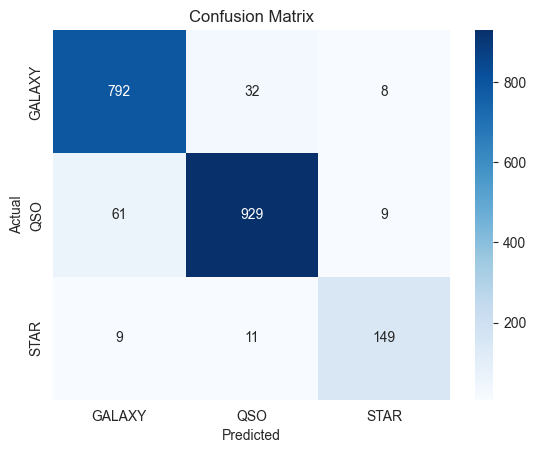

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best_gb)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [25]:
# Perform cross-validation on the best Gradient Boosting model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_gb, X_train_scaled, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")

Cross-validation scores: [0.930625 0.93125  0.946875 0.938125 0.9375  ]
Mean cross-validation score: 0.9369


## Feature Importance

C:\Users\Ian O'Connor\AppData\Local\Temp\ipykernel_53876\1475929309.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




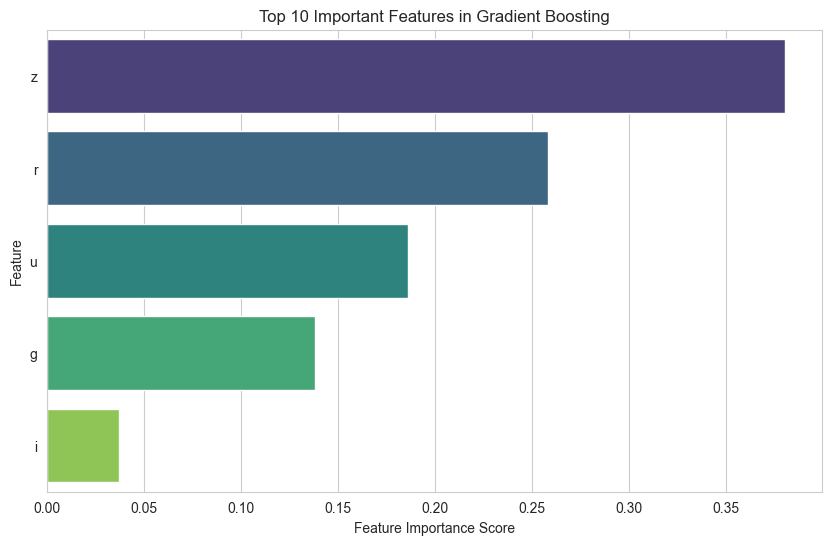

In [26]:
importances = best_gb.feature_importances_
feature_names = X_train.columns

# Sort feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices][:10], y=[feature_names[i] for i in sorted_indices[:10]], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Gradient Boosting")
plt.show()

## Principal Component Analysis (PCA)

In [27]:
# Apply PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [28]:
# Initialize Gradient Boosting Classifier with valid parameters
gb_model_pca = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=100)

# Train the model
gb_model_pca.fit(X_train_pca, y_train)

# Make predictions
y_pred_pca = gb_model_pca.predict(X_test_pca)

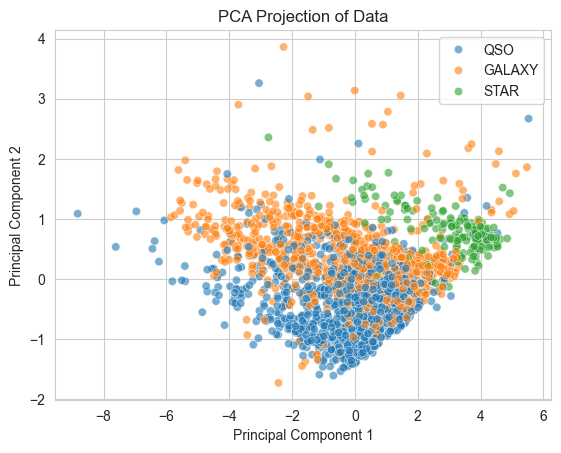

In [29]:
# Visualize PCA-transformed data
hue_labels = le.inverse_transform(y_test) if hasattr(le, "classes_") else y_test
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=hue_labels, alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Data")
plt.show()

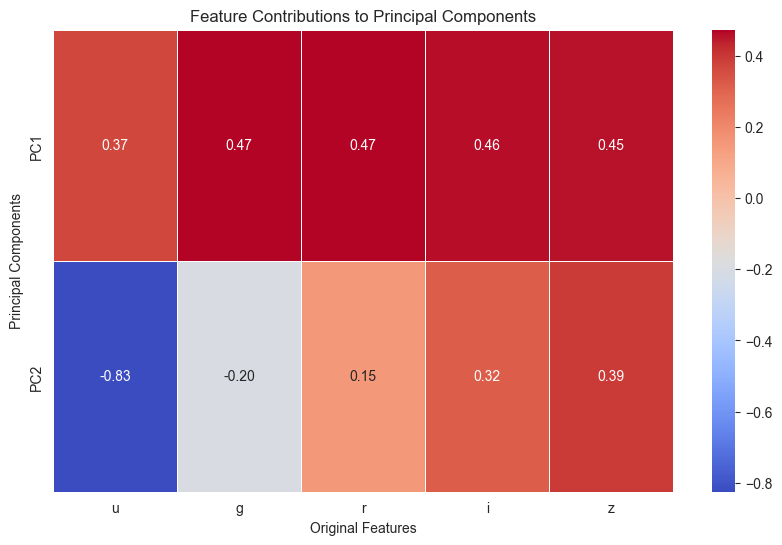

In [30]:
# Get feature importance in PCA
components_df = pd.DataFrame(pca.components_, columns=X_train.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# Plot the contributions of original features to the first two principal components
plt.figure(figsize=(10, 6))
sns.heatmap(components_df, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Contributions to Principal Components")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

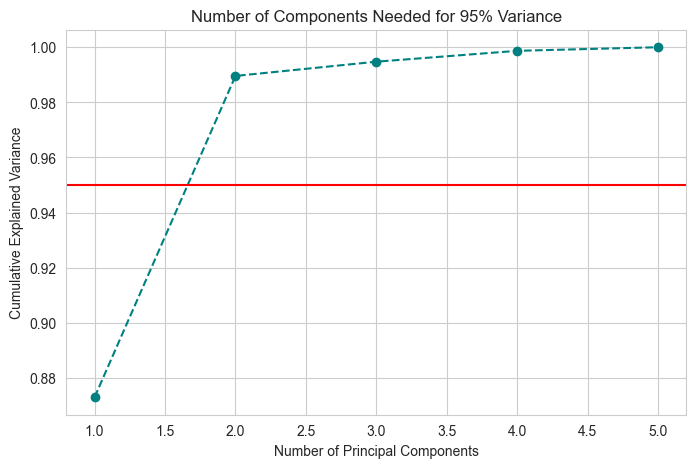

Number of principal components required for 95% variance: 2


In [31]:
pca_full = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='teal')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Number of Components Needed for 95% Variance")
plt.show()

# Print the number of components required for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of principal components required for 95% variance: {n_components_95}")

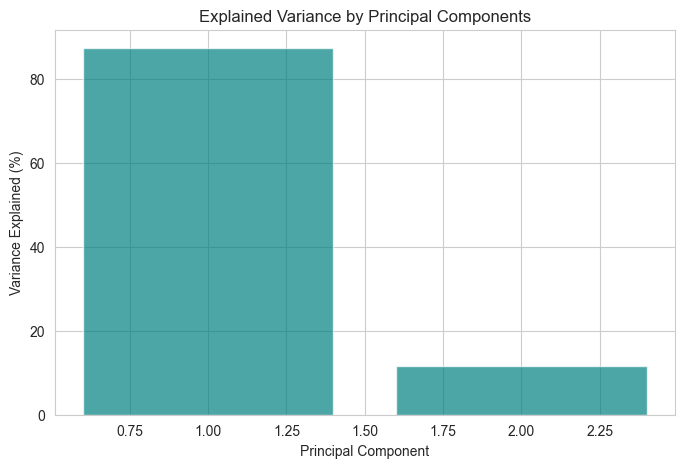

In [32]:
# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='teal', alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance by Principal Components")
plt.show()

In [ ]:
# Evaluate PCA-based GB
print("\nGradient Boosting Model with PCA Classification Report:")
print(classification_report(y_test, y_pred_pca, target_names=['star', 'galaxy', 'qso']))

# Train gb on full dataset (without PCA) for comparison
gb_model_full = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=100)
gb_model_full.fit(X_train_scaled, y_train)
y_pred_full = gb_model_full.predict(X_test_scaled)

# Evaluate gb without PCA
print("\nGB without PCA Classification Report:")
print(classification_report(y_test, y_pred_full, target_names=['star', 'galaxy', 'qso']))


Gradient Boosting Model with PCA Classification Report:
              precision    recall  f1-score   support

        star       0.71      0.70      0.71       832
      galaxy       0.78      0.79      0.78       999
         qso       0.81      0.82      0.81       169

    accuracy                           0.75      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.75      0.75      0.75      2000


SVM without PCA Classification Report:
              precision    recall  f1-score   support

        star       0.84      0.90      0.87       832
      galaxy       0.92      0.87      0.89       999
         qso       0.90      0.85      0.87       169

    accuracy                           0.88      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.88      0.88      0.88      2000

